In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA, convert_image
from parameters import *
from models import *

In [3]:
print(device)

cuda


In [4]:
scaling_factor = 2
crop_size = 96*scaling_factor
large_kernel_size = 9
small_kernel_size = 3
n_channels = 64
n_blocks = 16
lr_img_type = 'imagenet-norm'#'[0, 1]'#'gta-small-norm'#
hr_img_type = 'imagenet-norm'#'[0, 1]'#'[-1, 1]'

batch_size = 8
epochs = 5
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [5]:
criterion = nn.MSELoss().to(device)
#checkpoint = 'checkpoint_srresnet.pth.tar'
checkpoint = None
if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']
    optimizer = checkpoint['optimizer']
else:
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()),lr=lr)
    start_epoch = 0



truncated_vgg19 = TruncatedVGG19(i=5, j=4).to(device)
truncated_vgg19.eval()

c:\Users\Robert\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Robert\.pyenv\pyenv-win\versions\3.10.11\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TruncatedVGG19(
  (truncated_vgg19): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), s

In [6]:
def train(epochs = 3):
    criterion = nn.MSELoss().to(device)

    for epoch in range(epochs):
        print("EPOCH",epoch+start_epoch+1)
        running_loss = 0
        print_freq = 20
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
        for i,(lr_imgs, hr_imgs) in enumerate(loop):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            sr_imgs = model(lr_imgs)

            convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')

            sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
            hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()

            loss = criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)

            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
            if i % print_freq==print_freq-1:
                current_loss = running_loss / print_freq
                running_loss = 0

                loop.set_postfix(loss=current_loss)

In [7]:
def calculate_psnr(sr, hr, max_pixel_value=1.0):
    """
    Calculate PSNR between SR (super-resolved) and HR (high-resolution) images.
    Args:
        sr (numpy array): Super-resolved image.
        hr (numpy array): High-resolution ground-truth image.
        max_pixel_value (float): Maximum possible pixel value (1.0 for normalized images).
    Returns:
        psnr (float): Peak Signal-to-Noise Ratio.
    """
    mse = np.mean((sr - hr) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))
    return psnr




In [8]:
def evaluate():
    # Loop to calculate PSNR for the first 100 images
    psnr_list = []
    with torch.no_grad():
        for idx, (lr_img, hr_img) in enumerate(training_data):
            if idx >= 100:  # Limit to the first 100 images
                break

            # Evaluate the model
            model.eval()
            sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()

            sr_img = np.clip(sr_img, 0, 1)  # Clamp SR values to valid range [0, 1]
            hr_img = hr_img.permute(1, 2, 0).numpy()  # Convert HR tensor to numpy array
            
            # Calculate PSNR
            psnr = calculate_psnr(sr_img, hr_img, max_pixel_value=1.0)
            psnr_list.append(psnr)

    # Calculate average PSNR over 100 images
    average_psnr = np.mean(psnr_list)    
    return average_psnr * (-1) # higher PSNR is better so I multiply it by -1

In [9]:
best_result = float('inf')
best_architecture = None
for architecture in [(32,8),(64,16), (96,24)]:
    n_channels = architecture[0]
    n_blocks = architecture[1]
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_architecture = architecture
print(f'Best architecture is {best_architecture}')

best_result = float('inf')
best_loss = None
for loss in ['mse', 'mae', 'crossEntropy']:
    n_channels = best_architecture[0]
    n_blocks = best_architecture[1]
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)

    if loss== 'mse': loss_fn = torch.nn.MSELoss()
    elif loss== 'mae': loss_fn = torch.nn.L1Loss()
    elif loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
    else: raise RuntimeError("unable to handle error")

    optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_loss = loss
print(f'Best loss function is {best_loss}')

best_result = float('inf')
best_optimizer = None
for optimizer_name in ['adam', 'SGD', 'RMSprop']:
    n_channels = best_architecture[0]
    n_blocks = best_architecture[1]
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)

    if best_loss== 'mse': loss_fn = torch.nn.MSELoss()
    elif best_loss== 'mae': loss_fn = torch.nn.L1Loss()
    elif best_loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
    else: raise RuntimeError("unable to handle error")

    if optimizer_name == 'adam':optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)
    elif optimizer_name == 'SGD':optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)
    elif optimizer_name == 'RMSprop':optimizer = torch.optim.RMSprop(params=filter(lambda p: p.requires_grad, model.parameters()), lr=0.005)
    else: raise RuntimeError("unable to handle error")

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_optimizer = optimizer_name
print(f'Best optimizer is {best_optimizer}')

best_result = float('inf')
best_lr = None
for lr in [0.0025, 0.005, 0.01]:
    n_channels = best_architecture[0]
    n_blocks = best_architecture[1]
    model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)

    if best_loss== 'mse': loss_fn = torch.nn.MSELoss()
    elif best_loss== 'mae': loss_fn = torch.nn.L1Loss()
    elif best_loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
    else: raise RuntimeError("unable to handle error")

    if best_optimizer == 'adam':optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    elif best_optimizer == 'SGD':optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    elif best_optimizer == 'RMSprop':optimizer = torch.optim.RMSprop(params=filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    else: raise RuntimeError("unable to handle error")

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_lr = lr
print(f'Best learning rate is {best_lr}')

EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [00:49<00:00,  8.03it/s, loss=0.251]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [00:48<00:00,  8.21it/s, loss=0.28] 


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [00:48<00:00,  8.18it/s, loss=0.248]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [01:11<00:00,  5.52it/s, loss=0.306]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [01:12<00:00,  5.51it/s, loss=0.255]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [01:12<00:00,  5.51it/s, loss=0.341]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:12<00:00,  3.00it/s, loss=0.274]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:09<00:00,  3.06it/s, loss=0.253]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [01:59<00:00,  3.31it/s, loss=0.295]


Best architecture is (96, 24)
EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [01:59<00:00,  3.31it/s, loss=0.27] 


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [01:59<00:00,  3.32it/s, loss=0.254]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [01:59<00:00,  3.32it/s, loss=0.259]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [01:59<00:00,  3.32it/s, loss=0.268]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s, loss=0.305]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:12<00:00,  3.00it/s, loss=0.289]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:13<00:00,  2.97it/s, loss=0.25] 


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:12<00:00,  3.00it/s, loss=0.277]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s, loss=0.241]


Best loss function is mae
EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.264]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:10<00:00,  3.04it/s, loss=0.261]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.258]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:05<00:00,  3.15it/s, loss=0.229]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [01:58<00:00,  3.34it/s, loss=0.221]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:06<00:00,  3.15it/s, loss=0.237]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.264]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.237]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:10<00:00,  3.03it/s, loss=0.252]


Best optimizer is SGD
EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:11<00:00,  3.03it/s, loss=0.236]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.241]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:06<00:00,  3.14it/s, loss=0.225]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [01:58<00:00,  3.34it/s, loss=0.23] 


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [01:58<00:00,  3.34it/s, loss=0.229]


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:06<00:00,  3.13it/s, loss=0.213]


EPOCH 1


Epoch 1/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.247]


EPOCH 2


Epoch 2/3: 100%|██████████| 397/397 [02:11<00:00,  3.02it/s, loss=0.21] 


EPOCH 3


Epoch 3/3: 100%|██████████| 397/397 [02:01<00:00,  3.28it/s, loss=0.258]


Best learning rate is 0.0025


In [10]:
n_channels = best_architecture[0]
n_blocks = best_architecture[1]

model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor).to(device)

if best_loss== 'mse': loss_fn = torch.nn.MSELoss()
elif best_loss== 'mae': loss_fn = torch.nn.L1Loss()
elif best_loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
else: raise RuntimeError("unable to handle error")

if best_optimizer == 'adam':optimizer = torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)
elif best_optimizer == 'SGD':optimizer = torch.optim.SGD(params=filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)
elif best_optimizer == 'RMSprop':optimizer = torch.optim.RMSprop(params=filter(lambda p: p.requires_grad, model.parameters()), lr=best_lr)
else: raise RuntimeError("unable to handle error")

In [11]:
losses = []

for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        convert_image(sr_imgs, source='[-1, 1]', target='imagenet-norm')

        sr_imgs_in_vgg_space = truncated_vgg19(sr_imgs)
        hr_imgs_in_vgg_space = truncated_vgg19(hr_imgs).detach()

        loss = criterion(sr_imgs_in_vgg_space, hr_imgs_in_vgg_space)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)

    torch.save({'epoch': epoch+start_epoch,
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_srresnet_vgg19.pth.tar')

EPOCH 1


Epoch 1/5: 100%|██████████| 397/397 [01:59<00:00,  3.33it/s, loss=0.261]


EPOCH 2


Epoch 2/5: 100%|██████████| 397/397 [01:58<00:00,  3.34it/s, loss=0.243]


EPOCH 3


Epoch 3/5: 100%|██████████| 397/397 [01:58<00:00,  3.34it/s, loss=0.24] 


EPOCH 4


Epoch 4/5: 100%|██████████| 397/397 [01:59<00:00,  3.33it/s, loss=0.228]


EPOCH 5


Epoch 5/5: 100%|██████████| 397/397 [01:59<00:00,  3.34it/s, loss=0.242]


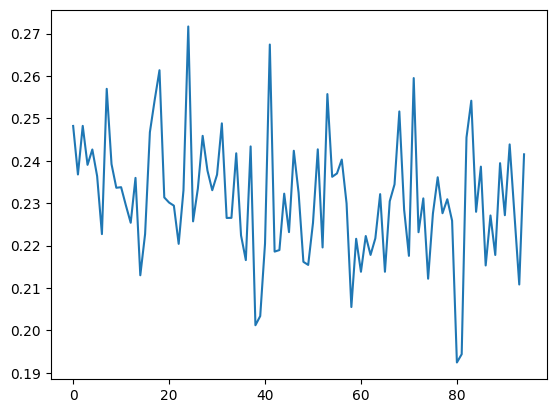

In [12]:
plt.plot(losses)
plt.show()

C:\Users\Robert\AppData\Local\Temp\ipykernel_27584\3034193142.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('checkpoint_srresnet_.pth.tar')
Cli

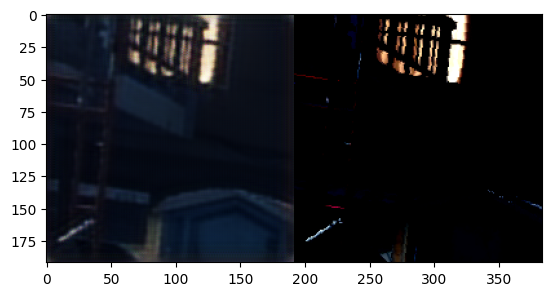

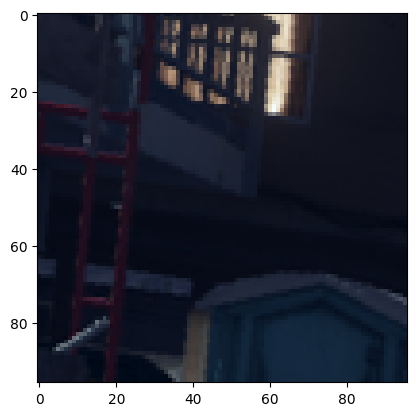

In [13]:
from srresnet import _NetD

checkpoint = torch.load('checkpoint_srresnet_.pth.tar')
model = checkpoint['model']
#model = SRResNet(large_kernel_size,small_kernel_size, n_channels, n_blocks, scaling_factor)

with torch.no_grad():
    for lr_img, hr_img in training_data:
        model.eval()
        sr_img = model(lr_img.unsqueeze(0)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        sr_img = (sr_img+1)/2
        sr_img = (sr_img - np.min(sr_img)) / (np.max(sr_img) - np.min(sr_img))
        plt.imshow(np.concatenate([sr_img, ((hr_img+1)/2).permute(1, 2, 0).numpy()], axis=1))
        plt.show()
        plt.imshow(((lr_img-torch.min(lr_img))/(torch.max(lr_img)-torch.min(lr_img))).permute(1, 2, 0).numpy())
        plt.show()
        break